## Pool-based Active Learning - Simple Evaluation Study

The main purpose of this tutorial is to show how a simple comparison study can be realized using `scikit-activeml`. For this experiment, we use a repeated K-fold Cross-validation to evaluate the query strategies using two different classifiers. Our main focus is cleanly separating the repetitions, proper handling of random states and separation of test and training data. 

In [9]:
import numpy as np
import matplotlib as mlp
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_blobs
from sklearn.model_selection import StratifiedKFold, KFold

from skactiveml.classifier import SklearnClassifier, ParzenWindowClassifier
from skactiveml.pool import UncertaintySampling, RandomSampling, DiscriminativeAL, CoreSet, TypiClust, Badge
from skactiveml.utils import call_func, MISSING_LABEL

import warnings
mlp.rcParams["figure.facecolor"] = "white"
warnings.filterwarnings("ignore")

import mlflow

mlflow.set_tracking_uri(uri="http://localhost:8888")

## Random Seed Management
To guarantee that the experiment is reproducible, we have to set the random states for all components that might use one. To simplify this, we make all random seeds dependent of a single fixed random state and use helper functions to generate new seeds and random states. Keep in mind that the `master_random_state` should only be used to create new random states or random seeds.

In [10]:
master_random_state = np.random.RandomState(0)

def gen_seed(random_state:np.random.RandomState):
    return random_state.randint(0, 2**31)

def gen_random_state(random_state:np.random.RandomState):
    return np.random.RandomState(gen_seed(random_state))

## Data Set Generation
We generate a data set of 100 data points with two clusters from the `make_blobs` method of `scikit-learn`. This method also returns the true labels of each data point. In practice, however, we do not know these labels unless we ask an oracle. The labels are stored in `y_true`, which acts as an oracle.

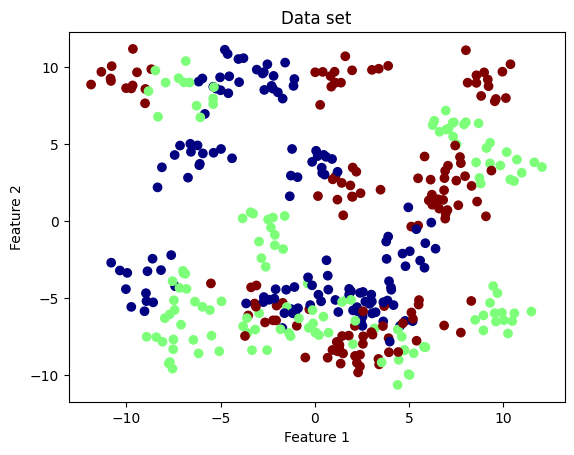

In [11]:
n_features = 2
n_classes = 3
n_centers_per_class = 10
classes = np.arange(n_classes)
X, centers = make_blobs(
    n_features=n_features, centers=n_classes*n_centers_per_class, n_samples=400,
    random_state=gen_seed(master_random_state))
y_true = centers % n_classes
bound = [[min(X[:, 0]), min(X[:, 1])], [max(X[:, 0]), max(X[:, 1])]]
plt.scatter(X[:, 0], X[:, 1], c=y_true, cmap='jet')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Data set');

## Classification Models and Query Strategies
We handle the creation of classifiers and query strategies using factory functions to simplify the separation of classifiers and query strategies across repetitions and folds.

In [12]:
classifier_factory_functions = {
    #'LogisticRegression': lambda classes, random_state: SklearnClassifier(
        #LogisticRegression(),
        #classes=classes,
        #random_state=gen_seed(random_state)
    #),
    'ParzenWindowClassifier': lambda classes, random_state: ParzenWindowClassifier(
        classes=classes,
        random_state=gen_seed(random_state)
    )
}

query_strategy_factory_functions = {
    'RandomSampling': lambda random_state: RandomSampling(random_state=gen_seed(random_state)),
    'UncertaintySampling': lambda random_state: UncertaintySampling(random_state=gen_seed(random_state)),
    'DiscriminativeAL': lambda random_state: DiscriminativeAL(random_state=gen_seed(random_state)),
    'CoreSet': lambda random_state: CoreSet(random_state=gen_seed(random_state)),
    'TypiClust': lambda random_state: TypiClust(random_state=gen_seed(random_state)),
    'Badge': lambda random_state: Badge(random_state=gen_seed(random_state))
}

query_strategy_params_undefault = {
    'RandomSampling': {} ,
    'UncertaintySampling': {},
    'DiscriminativeAL': {}, 
    'CoreSet': {},
    'TypiClust': {},
    'Badge': {}
}

def create_classifier(name, classes, random_state):
    return classifier_factory_functions[name](classes, random_state)

def create_query_strategy(name, random_state):
    return query_strategy_factory_functions[name](random_state)

def set_query_param_undefault(name, param):
    query_param = query_strategy_params_undefault[name]
    if name == 'UncertaintySampling':
        query_param['clf'] = param
    elif name == 'DiscriminativeAL':
        query_param['discriminator'] = param
    elif name == 'Badge':
        query_param['clf'] = param
    return query_param

## Experiment Parameters

For this experiment, we need to define how the strategies should be compared against one another. As we want to use a repeated K-Fold Cross-validation, we need to define the number of repetitions (`n_reps`), the number of folds (`n_folds`) and the number of queries within each fold. Furthermore, we have the option of using stratified Cross-validation.

In [13]:
n_reps = 10
n_folds = 5
n_cycles = 50
use_stratified = True
classifier_names = classifier_factory_functions.keys()
query_strategy_names = query_strategy_factory_functions.keys()

## Experiment Loop

The actual experiment loops over all query strategy and classifier combinations. The average accuracy over the test set is recorded for each cycle and stored in the `results` dictionary.

In [14]:
results = {}
kfold_class = StratifiedKFold if use_stratified else KFold

for clf_name in classifier_names:
    for qs_name in query_strategy_names:
        accuracies = np.full((n_reps, n_folds, n_cycles), np.nan)
        for i_rep in range(n_reps):
            kf = kfold_class(n_splits=n_folds, shuffle=True, random_state=gen_seed(master_random_state))
            for i_fold, (train_idx, test_idx) in enumerate(kf.split(X, y_true)):
                X_test = X[test_idx]
                y_test = y_true[test_idx]

                X_train = X[train_idx]
                y_train_true = y_true[train_idx]
                y_train = np.full(shape=y_train_true.shape, fill_value=MISSING_LABEL)

                clf = create_classifier(clf_name, classes, gen_random_state(master_random_state))
                qs = create_query_strategy(qs_name, gen_random_state(master_random_state))
                clf.fit(X_train, y_train)
                
                for c in range(n_cycles):
                    query_idx = call_func(qs.query, X=X_train, y=y_train, batch_size=1, clf=clf, discriminator=clf)
                    y_train[query_idx] = y_train_true[query_idx]
                    clf.fit(X_train, y_train)
                    accuracies[i_rep, i_fold, c] = clf.score(X_test, y_test)
        results[(clf_name, qs_name)] = accuracies

## Result Plotting
We use learning curves to compare the strategies. For that, we plot the average accuracy (averaged over all repetitions and folds) relative to the number of queries. The error bars show the standard deviation for each curve. Furthermore, the legend shows the area under the learning curve, i.e., mean accuracy over all cycles.

In [ ]:
for clf_name in classifier_names:
    for qs_name in query_strategy_names:
        key = (clf_name, qs_name)
        result = results[key]
        reshaped_result = result.reshape((-1, n_cycles))
        errorbar_mean = np.mean(reshaped_result, axis=0)
        errorbar_std = np.std(reshaped_result, axis=0)
        plt.errorbar(np.arange(n_cycles), errorbar_mean, errorbar_std, label=f"({np.mean(errorbar_mean):.4f}) {qs_name}", alpha=0.5)
    plt.title(clf_name)
    plt.legend(loc='lower right')
    plt.xlabel('cycle')
    plt.ylabel('accuracy')
    plt.show()

## Load the result
Load the result with mlflow

In [ ]:
# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")

# Create a new MLflow Experiment
mlflow.set_experiment("Evaluation")

# Start an MLflow run
with mlflow.start_run():
    for clf_name in classifier_names:
        for qs_name in query_strategy_names:
            key = (clf_name, qs_name)
            result = results[key]
            reshaped_result = result.reshape((-1, n_cycles))
            errorbar_mean = np.mean(reshaped_result, axis=0)
            errorbar_std = np.std(reshaped_result, axis=0)
            
            mlflow.log_metric(f"errorbar_mean for {qs_name} with {clf_name}", errorbar_mean[-1])
            mlflow.log_metric(f"errorbar_std for {qs_name} with {clf_name}", errorbar_std[-1])

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Training Info", "Basic LR model for make blobs")
